## Straight forward DC-GAN for reference

We just want something proven so we rip the tensoflow DCGAN tutorial.
https://www.tensorflow.org/tutorials/generative/dcgan


In [1]:
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
#import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

#from IPython import display

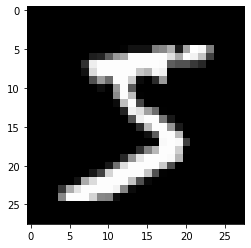

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[0],cmap = 'gray')
plt.show()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

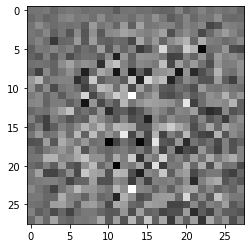

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00059377]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        #display.clear_output(wait=True)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
            pass

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [17]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 7.8026816844940186 sec
Time for epoch 2 is 5.882169961929321 sec
Time for epoch 3 is 5.866613388061523 sec
Time for epoch 4 is 5.920602560043335 sec
Time for epoch 5 is 5.94271445274353 sec
Time for epoch 6 is 5.946311950683594 sec
Time for epoch 7 is 5.956172704696655 sec
Time for epoch 8 is 6.01875376701355 sec
Time for epoch 9 is 6.088724613189697 sec
Time for epoch 10 is 6.13819146156311 sec
Time for epoch 11 is 6.157017230987549 sec
Time for epoch 12 is 6.153329849243164 sec
Time for epoch 13 is 6.223413944244385 sec
Time for epoch 14 is 6.198326826095581 sec
Time for epoch 15 is 6.191771745681763 sec
Time for epoch 16 is 6.200411319732666 sec
Time for epoch 17 is 6.1915364265441895 sec
Time for epoch 18 is 6.186851739883423 sec
Time for epoch 19 is 6.2191760540008545 sec
Time for epoch 20 is 6.205912113189697 sec
Time for epoch 21 is 6.2043397426605225 sec
Time for epoch 22 is 6.211989164352417 sec
Time for epoch 23 is 6.201655864715576 sec
Time for epoch 24 i

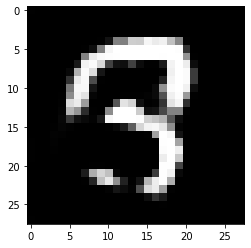

In [25]:
noise = tf.random.normal([3, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()